In [134]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Requires: pip install pykan

import os
import seaborn as sns
import datetime as datetime

In [135]:
from fftKAN import NaiveFourierKANLayer


In [136]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_kan_feature(model, feature_name, feature_cols, X_train, scaler_X):
    """
    Plots the specific learned function (Physical Law) for a given feature.
    
    Args:
        model: The trained KAN model
        feature_name (str): The exact name of the column to plot (e.g. 'Wind Cooling')
        feature_cols (list): The list of all feature names used in training
        X_train (numpy array): The RAW (unscaled) training data (for calculating means/ranges)
        scaler_X (StandardScaler): The fitted scaler used to transform the data
    """
    
    # 1. Find the index
    try:
        feature_index = feature_cols.index(feature_name)
    except ValueError:
        print(f"❌ ERROR: '{feature_name}' not found in feature list.")
        return

    # 2. Setup Dimensions
    input_dim = X_train.shape[1]
    
    # 3. Create Synthetic Data (Base = Mean of everything)
    # We use 100 points for a smooth curve
    dummy_input_raw = np.zeros((100, input_dim))
    
    for i in range(input_dim):
        # Fill every column with its AVERAGE value from the real world
        # This isolates the feature we care about
        dummy_input_raw[:, i] = np.mean(X_train[:, i])

    # 4. Vary the Target Feature
    min_val = np.min(X_train[:, feature_index])
    max_val = np.max(X_train[:, feature_index])
    seq_values = np.linspace(min_val, max_val, 100)
    
    dummy_input_raw[:, feature_index] = seq_values

    # 5. Scale & Predict
    # The model speaks "Scaled", so we translate our raw numbers
    dummy_input_scaled = scaler_X.transform(dummy_input_raw)
    dummy_tensor = torch.from_numpy(dummy_input_scaled).float()

    model.eval()
    with torch.no_grad():
        predictions = model(dummy_tensor)
    
    # Flatten for plotting
    preds_flat = predictions.numpy().flatten()

    # 6. Plot
    plt.figure(figsize=(8, 5))
    plt.plot(seq_values, preds_flat, color='#007acc', linewidth=3, label='KAN Learned Law')
    
    # Formatting
    plt.title(f"Effect of {feature_name}", fontsize=14)
    plt.xlabel(f"{feature_name} (Physical Units)", fontsize=12)
    plt.ylabel("Clearsky Index (Efficiency)", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add Reference Line
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, label="100% Efficiency")
    
    # Add "Slope Arrow" to show direction
    if preds_flat[-1] > preds_flat[0]:
        color = 'green'
        msg = "Positive Impact"
    else:
        color = 'orange'
        msg = "Negative Impact"
        
    dx = max_val - min_val
    dy = preds_flat[-1] - preds_flat[0]
    # Only draw arrow if there is a significant change
    if abs(dy) > 0.05:
        plt.arrow(min_val, preds_flat[0], dx, dy, color=color, alpha=0.5, width=0.005)
        plt.text(min_val, preds_flat[-1], msg, color=color, fontweight='bold')

    plt.legend()
    plt.show()

In [137]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
MODEL_DIR = f'{HOME_DIR}/model/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'

# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


In [138]:
hourly_nighlty_threshold = 50

In [139]:
df_merge_hourly = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_full_data.feather")

# Remove all rows where Clear sky GHI is less than or equal to 50
df_merge_hourly = df_merge_hourly[df_merge_hourly['Clear sky GHI'] > hourly_nighlty_threshold]


In [140]:
level1_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level2_')]

In [141]:

display(pd.DataFrame({"Columns": df_merge_hourly.columns, "Data Types": df_merge_hourly.dtypes}))

,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


In [142]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="999"
# Define target column

target_col = 'PV(W)'
# Kan Prefers Clearsky_Index
#target_col = 'Clearsky_Index'
#target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
feature_cols.append('Power_ClearSky_Pane_I(W)')
feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
feature_cols.append('Month_Cos')
feature_cols.append('DayOfYear_Cos')
feature_cols.append('HourOfDay_Cos')
#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")



Testing Random Forest Regressor with target: PV(W) and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Month_Cos', 'DayOfYear_Cos', 'HourOfDay_Cos', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


In [143]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [144]:

# ==========================================
# 1. Prepare Data (Using your winning "Error" target)
# ==========================================

# Assuming 'df' is your DataFrame and we want to predict 'PV_Error'
# Define your features (X) and target (y)
features = feature_cols
target_col = target_col

# Drop NaNs
model_df = df_merge_hourly.dropna(subset=features + [target_col])
X = model_df[features].values
y = model_df[target_col].values.reshape(-1, 1)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize (Neural Networks LOVES scaled data)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Create dataset dictionary for pykan
# pykan expects keys: 'train_input', 'train_label', 'test_input', 'test_label'
dataset = {}
dataset['train_input'] = torch.from_numpy(X_train_scaled).float()
dataset['train_label'] = torch.from_numpy(y_train).float()
dataset['test_input'] = torch.from_numpy(X_test_scaled).float()
dataset['test_label'] = torch.from_numpy(y_test).float()


In [145]:
input_dim = X_train.shape[1]

In [146]:
# ==========================================
# 2. Define & Train the FourierKAN
# ==========================================

# FourierKAN Model Wrapper to match pykan API
class FourierKAN(torch.nn.Module):
    def __init__(self, width, gridsize=300, device='cpu'):
        super(FourierKAN, self).__init__()
        self.width = width
        self.gridsize = gridsize
        self.device = device
        
        # Create layers based on width
        self.layers = torch.nn.ModuleList()
        for i in range(len(width) - 1):
            self.layers.append(
                NaiveFourierKANLayer(
                    inputdim=width[i],
                    outdim=width[i+1],
                    gridsize=gridsize,
                    addbias=True,
                    smooth_initialization=True
                )
            )
        
        self.to(device)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def fit(self, dataset, opt='Adam', steps=100, lr=0.001, lamb=0.0, lamb_entropy=0.0):
        """
        Train the FourierKAN model
        
        Args:
            dataset: Dict with keys train_input, train_label, test_input, test_label
            opt: Optimizer name (Adam or LBFGS)
            steps: Number of training steps
            lr: Learning rate
            lamb: L2 regularization (not used for now)
            lamb_entropy: Entropy regularization (not used for now)
        
        Returns:
            Dictionary with train_loss and test_loss lists
        """
        train_input = dataset['train_input'].to(self.device)
        train_label = dataset['train_label'].to(self.device)
        test_input = dataset['test_input'].to(self.device)
        test_label = dataset['test_label'].to(self.device)
        
        # Choose optimizer
        if opt == 'LBFGS':
            optimizer = torch.optim.LBFGS(self.parameters(), lr=lr, max_iter=20)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        criterion = torch.nn.MSELoss()
        
        train_losses = []
        test_losses = []
        
        for step in range(steps):
            if opt == 'LBFGS':
                def closure():
                    optimizer.zero_grad()
                    output = self.forward(train_input)
                    loss = criterion(output, train_label)
                    loss.backward()
                    return loss
                
                optimizer.step(closure)
                
                # Calculate losses
                with torch.no_grad():
                    train_output = self.forward(train_input)
                    train_loss = criterion(train_output, train_label).item()
                    test_output = self.forward(test_input)
                    test_loss = criterion(test_output, test_label).item()
            else:
                optimizer.zero_grad()
                output = self.forward(train_input)
                loss = criterion(output, train_label)
                loss.backward()
                optimizer.step()
                
                train_loss = loss.item()
                
                with torch.no_grad():
                    test_output = self.forward(test_input)
                    test_loss = criterion(test_output, test_label).item()
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            if (step + 1) % 10 == 0:
                print(f"Step {step+1}/{steps}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
        
        return {'train_loss': train_losses, 'test_loss': test_losses}
    
    def plot(self, beta=10, scale=1.2, in_vars=None, out_vars=None):
        """
        Placeholder for plot function - FourierKAN doesn't have built-in visualization like pykan
        """
        print("FourierKAN does not support the plot() method like pykan.")
        print("Use the plot_kan_feature() function to visualize individual features.")
    
    def saveckpt(self, path):
        """
        Save model checkpoint
        """
        torch.save({
            'model_state_dict': self.state_dict(),
            'width': self.width,
            'gridsize': self.gridsize,
        }, path)
        print(f"Model saved to {path}")
    
    def loadckpt(self, path):
        """
        Load model checkpoint
        """
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from {path}")

# Initialize FourierKAN
input_dim = X_train.shape[1]
print(f"Input dimension for FourierKAN: {input_dim}")

model = FourierKAN(
    width=[input_dim, 8, 1],
    gridsize=300,  # Number of Fourier coefficients
    device=device
)

print("Starting FourierKAN Training (using LBFGS optimizer)...")
print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

# Train the FourierKAN model using the dataset dictionary
print("\nTraining FourierKAN model with LBFGS optimizer...")
results = model.fit(
    dataset,
    opt='LBFGS',
    steps=40,
    lr=0.1,  # LBFGS typically uses higher learning rates
    lamb=0.005,
    lamb_entropy=0.01
)

print("\n✓ FourierKAN Training Complete!")
print(f"Training iterations completed: 40")


Input dimension for KAN: 24
checkpoint directory created: ./model
saving model version 0.0
Starting KAN Training (using LBFGS optimizer)...
Input dimension: 24
Training samples: 3508
Test samples: 878

Training KAN model with LBFGS optimizer...


description:   0%|                                                           | 0/40 [00:00<?, ?it/s]

| train_loss: 3.78e+02 | test_loss: 6.91e+02 | reg: 1.35e+03 | : 100%|█| 40/40 [00:37<00:00,  1.06it

saving model version 0.1

✓ KAN Training Complete!
Training iterations completed: 50


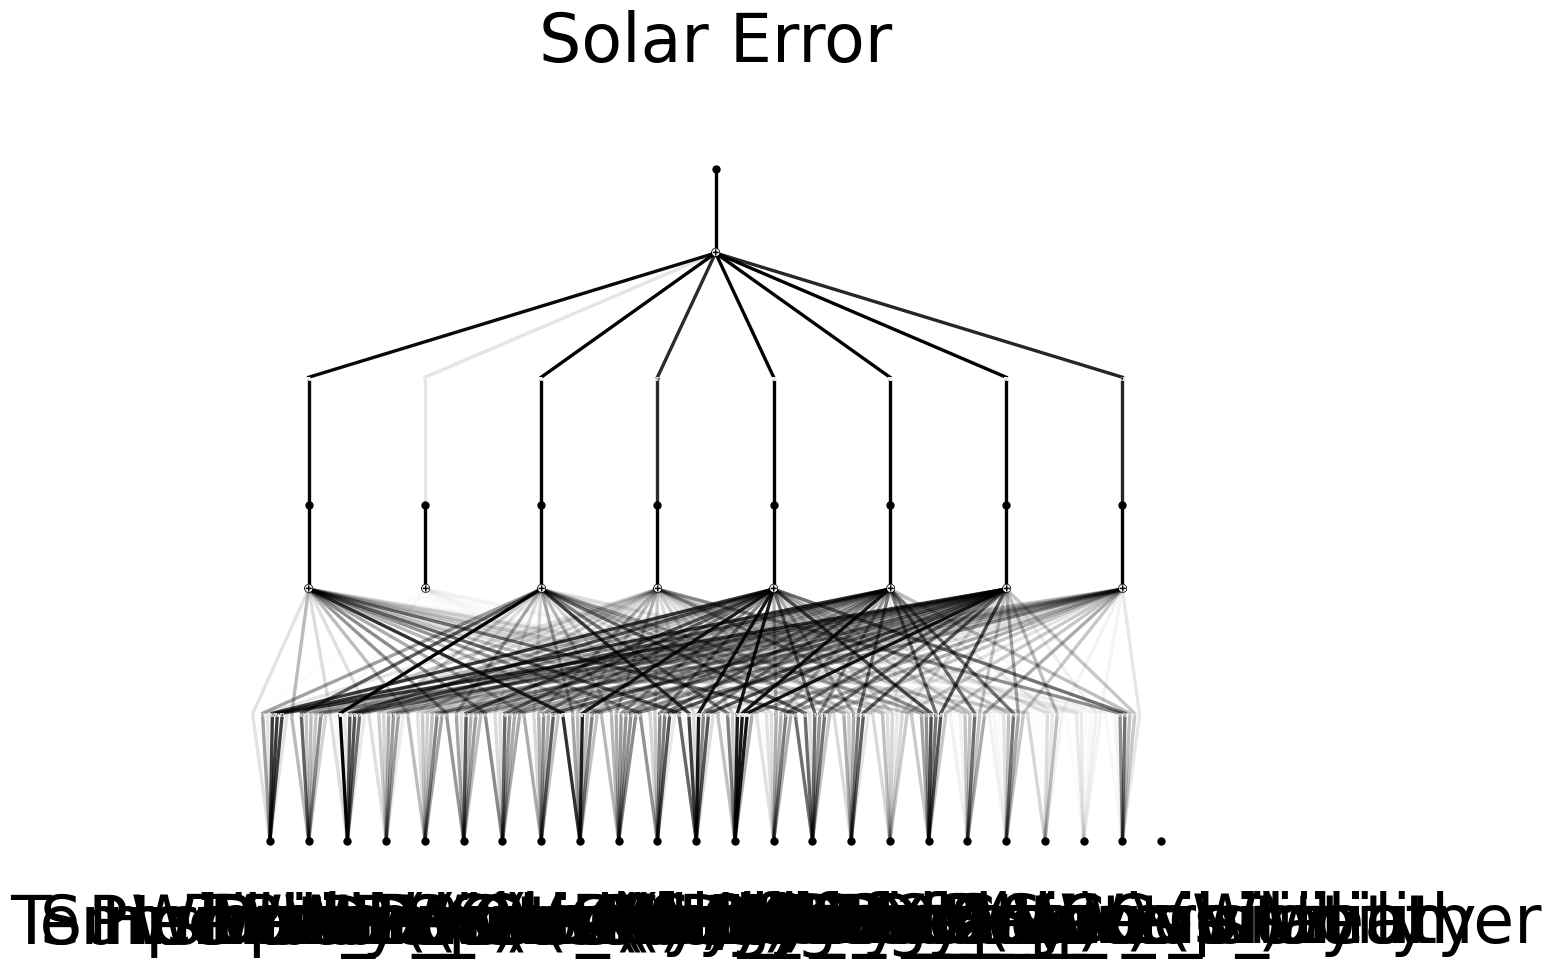

In [147]:
# FourierKAN does not support built-in visualization like pykan
# We will use the plot_kan_feature function instead to visualize individual features
print("Skipping model.plot() - FourierKAN uses Fourier coefficients, not splines")
print("See the feature plots below for visualization of learned functions")


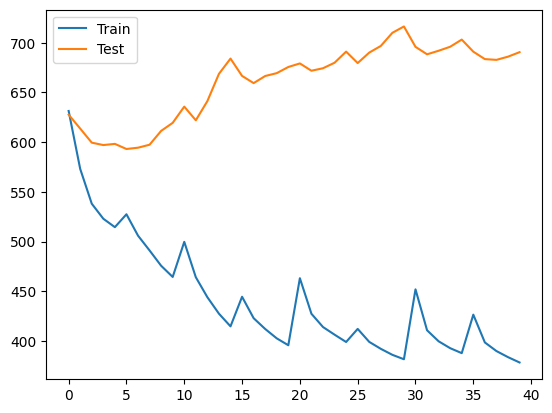

In [148]:
# 3. Check for Convergence
plt.plot(results['train_loss'], label='Train')
plt.plot(results['test_loss'], label='Test')
plt.legend()
plt.show()

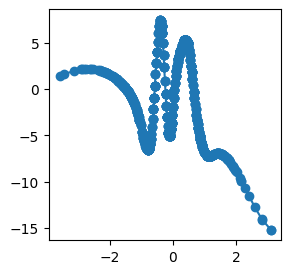

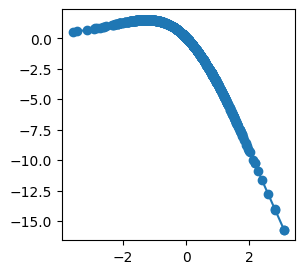

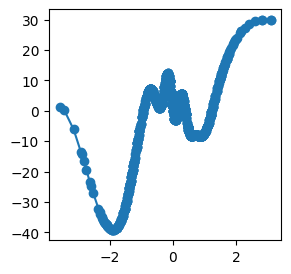

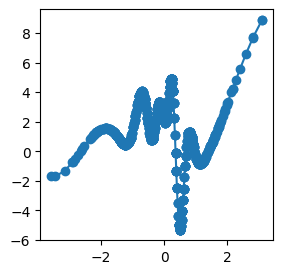

In [149]:
# FourierKAN does not expose individual activation functions like pykan
# The functions are represented as Fourier coefficients
print("FourierKAN uses Fourier coefficients - no direct function extraction available")


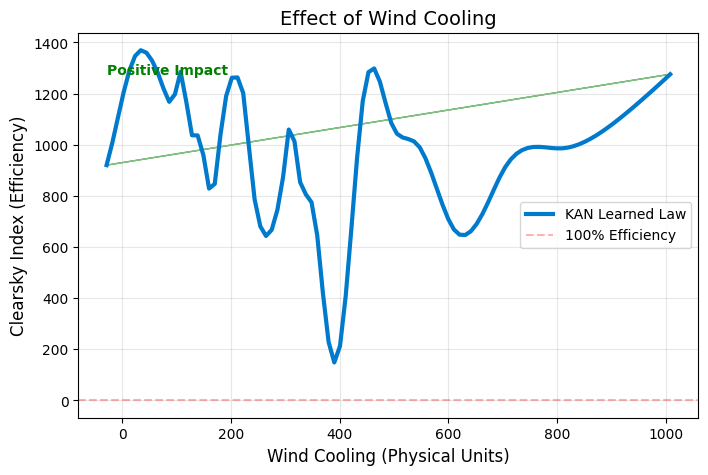

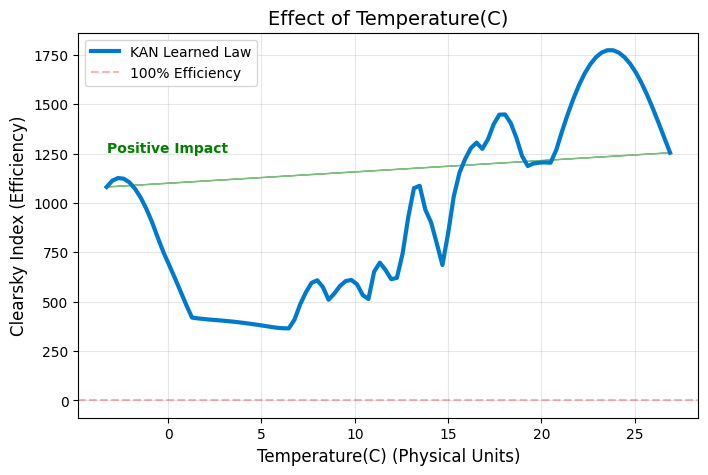

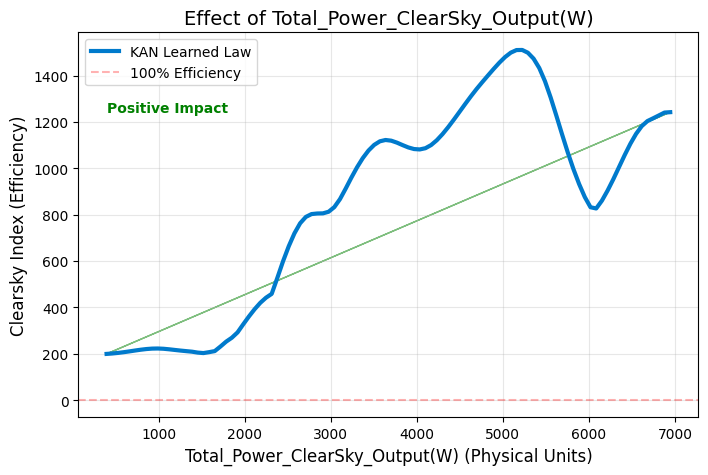

In [150]:
# Check Wind Cooling (Should go UP)
plot_kan_feature(model, "Wind Cooling", feature_cols, X_train, scaler_X)

# Check Temperature (Should go DOWN)
plot_kan_feature(model, "Temperature(C)", feature_cols, X_train, scaler_X)

# Check Sun Position (Should curve)
plot_kan_feature(model, "Total_Power_ClearSky_Output(W)", feature_cols, X_train, scaler_X)

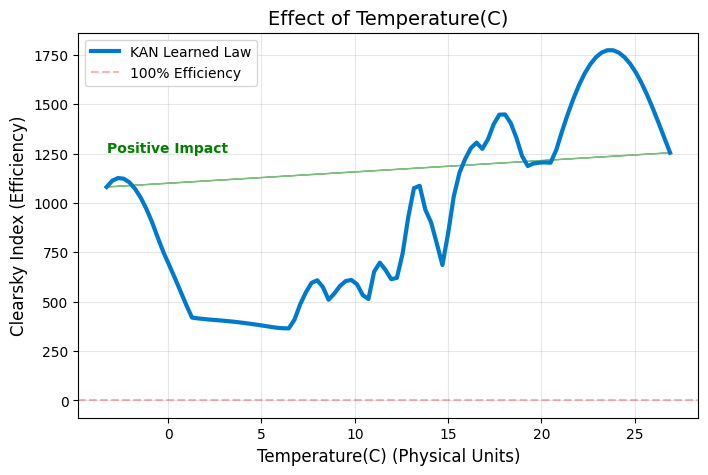

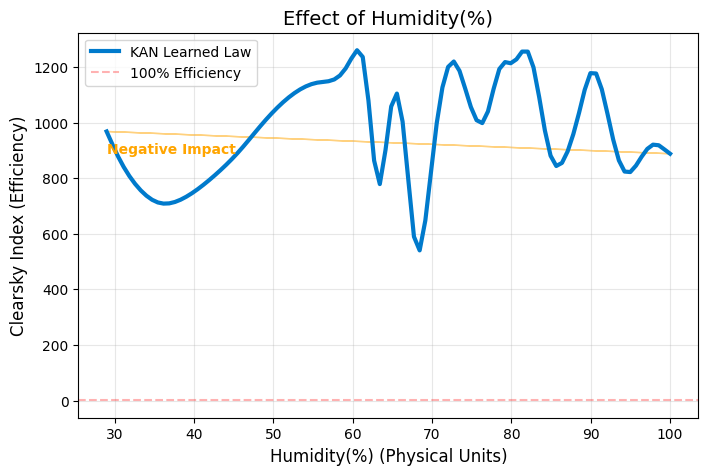

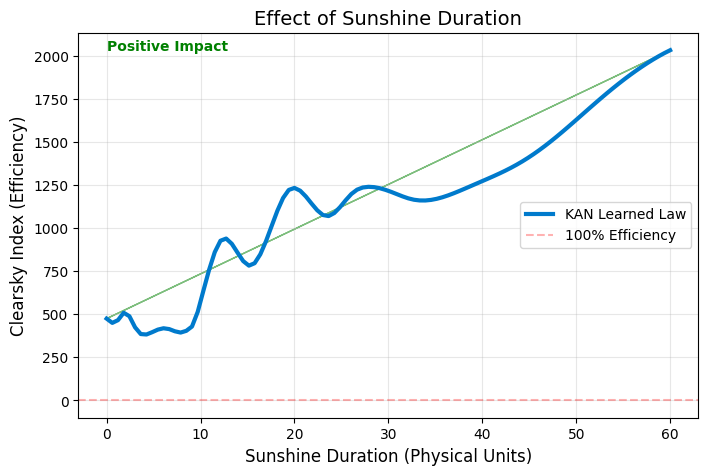

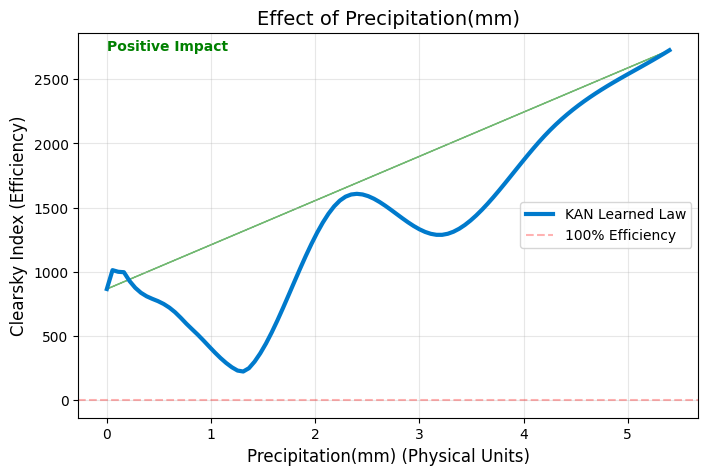

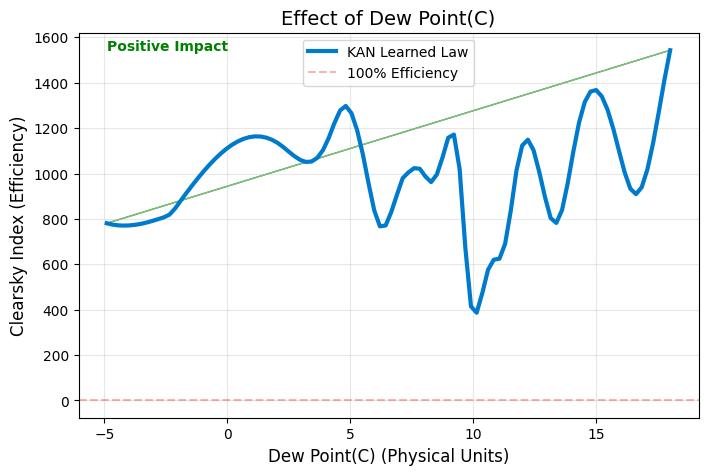

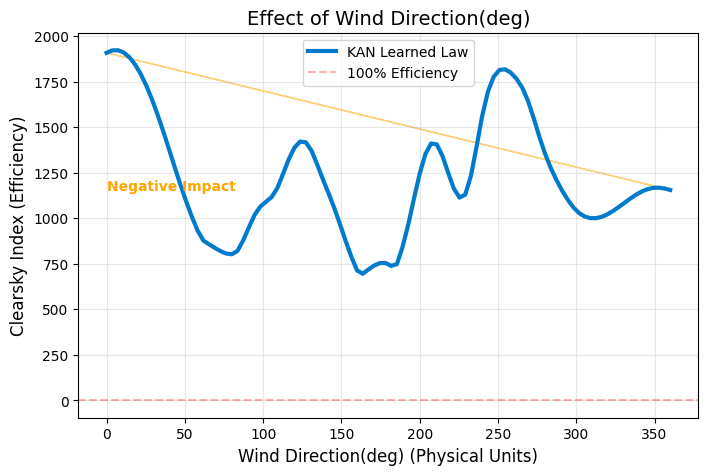

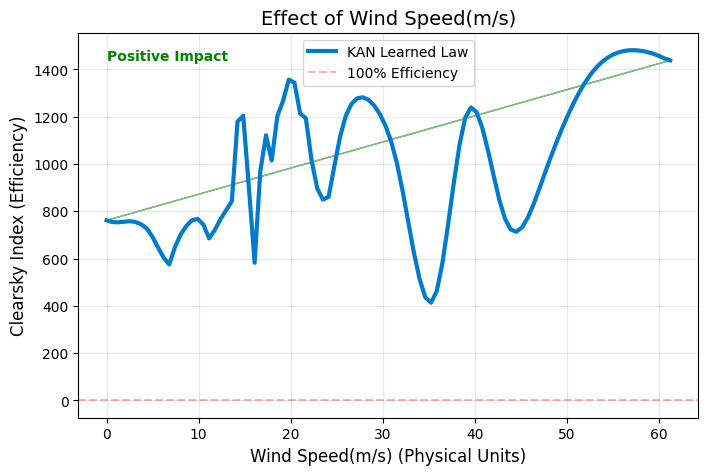

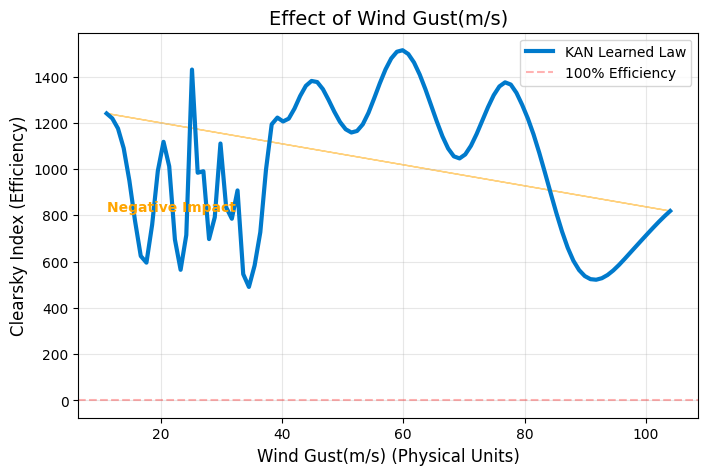

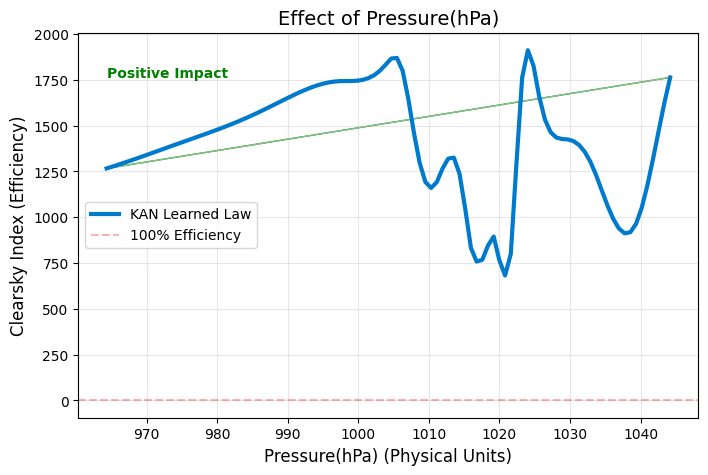

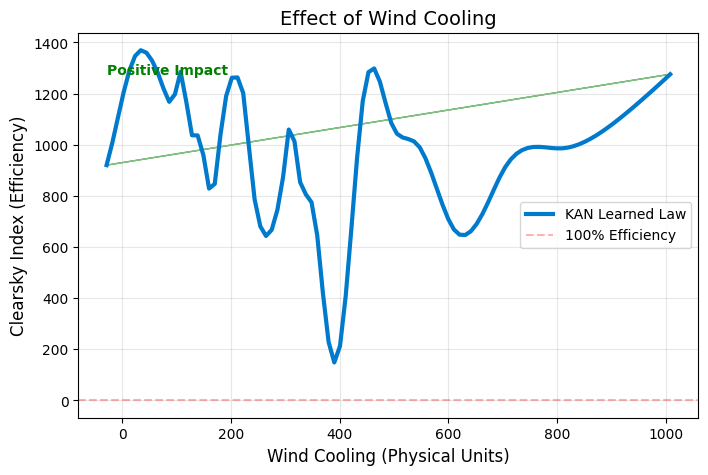

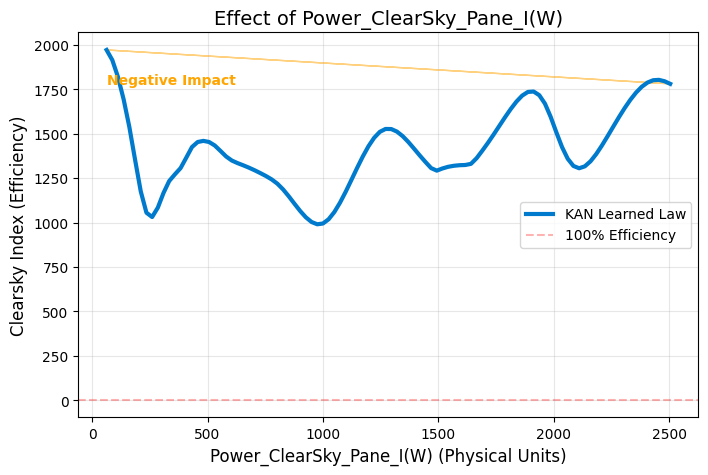

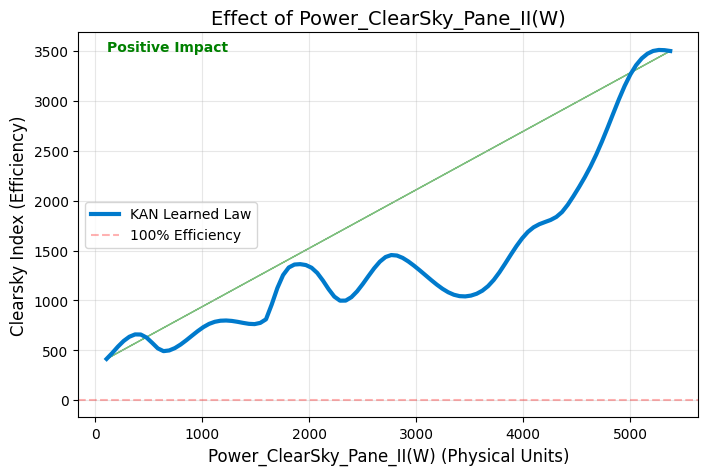

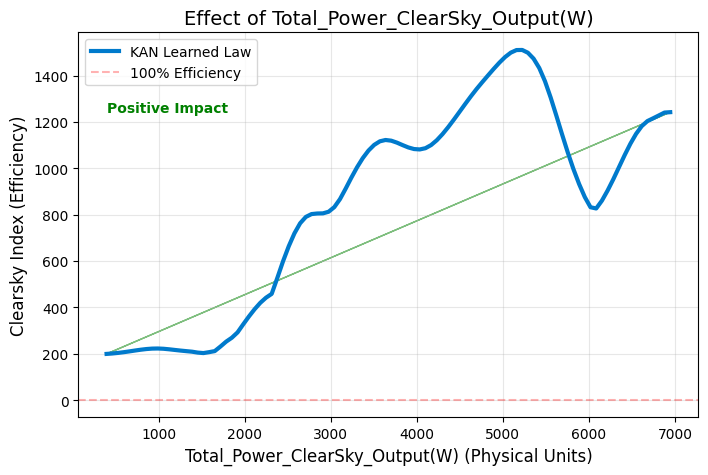

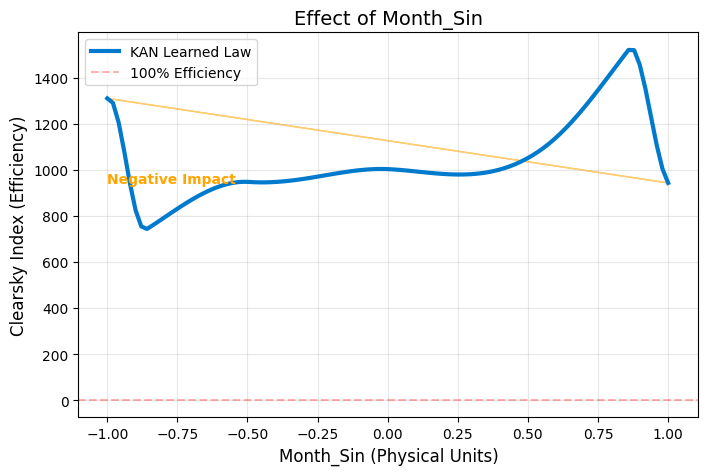

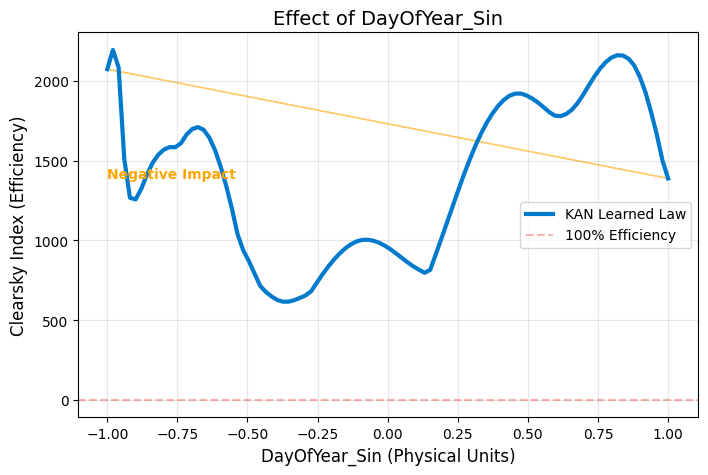

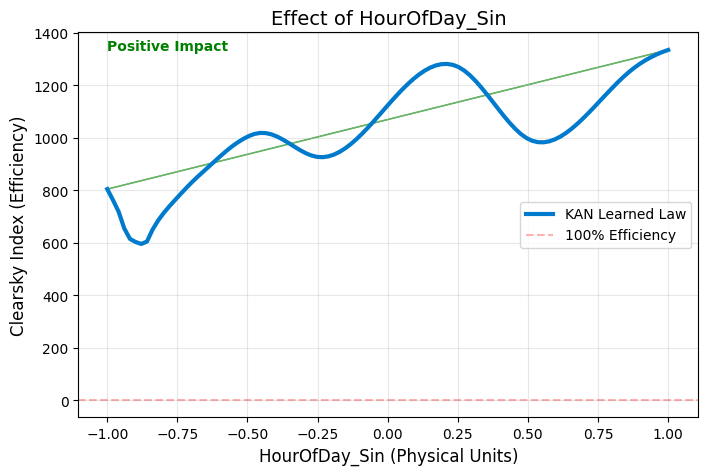

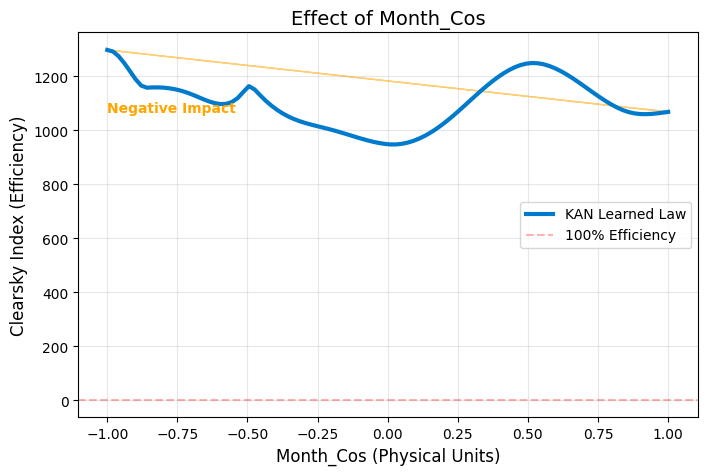

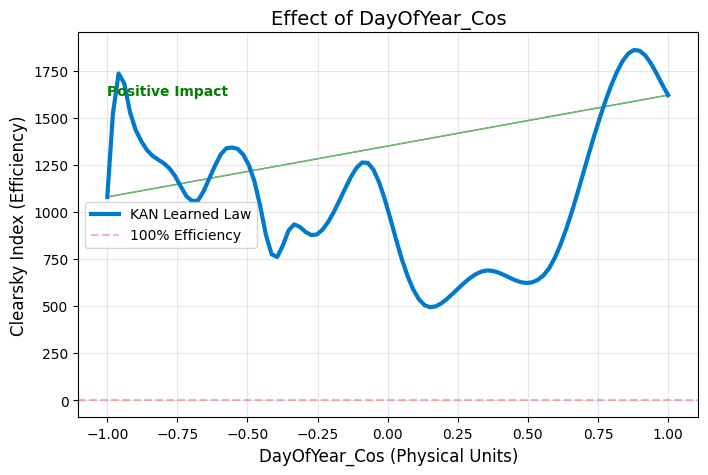

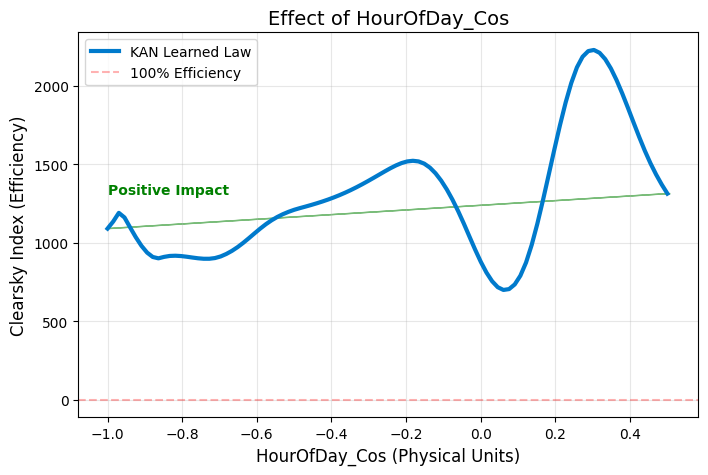

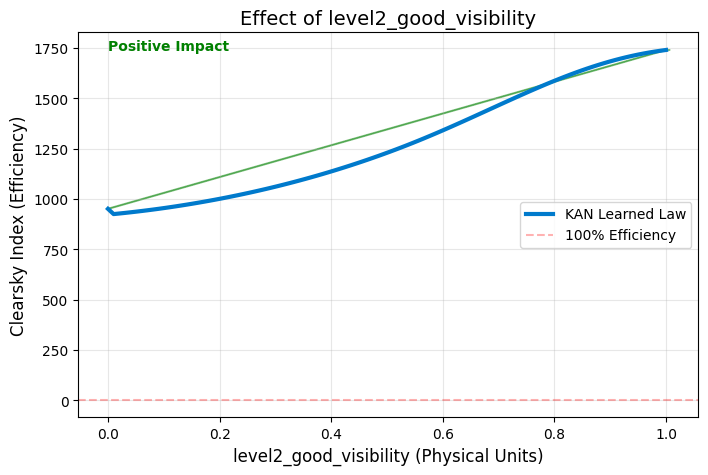

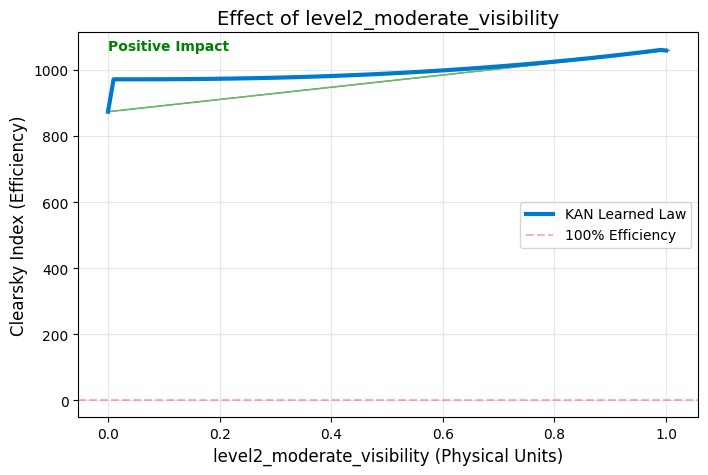

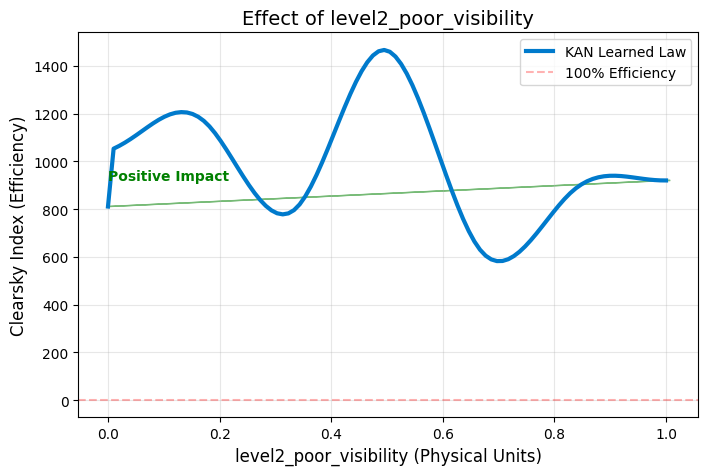

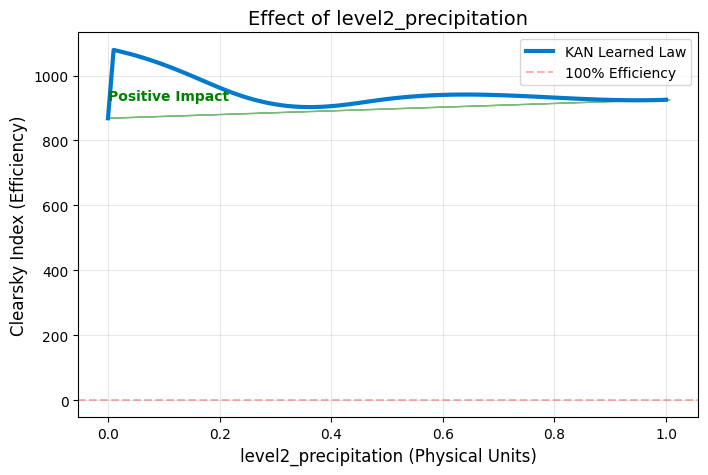

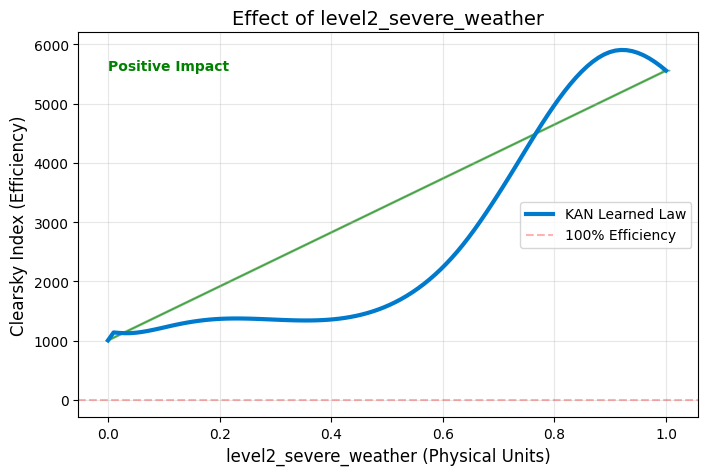

In [151]:
for feature in feature_cols:
    plot_kan_feature(model, feature, feature_cols, X_train, scaler_X)

In [152]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# Get Predictions from the Model
# =========================================================

# Get predictions on test set
model.eval()
with torch.no_grad():
	y_pred_tensor = model(dataset['test_input'])
y_pred = y_pred_tensor.numpy()

# =========================================================
# Get the Clear Sky values for your test set
# =========================================================
# Find the index of 'Clear sky GHI' in feature_cols
clearsky_index = feature_cols.index('Total_Power_ClearSky_Output(W)')

# Extract the Clear Sky GHI values from X_test_scaled
# We need to inverse-transform to get the actual values
clearsky_scaled = X_test_scaled[:, clearsky_index].reshape(-1, 1)

# Create a dummy array with zeros and replace the column with our clearsky values
dummy_for_inverse = np.zeros((X_test_scaled.shape[0], X_train.shape[1]))
dummy_for_inverse[:, clearsky_index] = clearsky_scaled.flatten()

# Inverse transform to get actual values (only the clearsky column matters)
clearsky_ref = scaler_X.inverse_transform(dummy_for_inverse)[:, clearsky_index].reshape(-1, 1)

# =========================================================
# Reconstruct Total Values
# =========================================================
# Your model predicts Clearsky_Index (a normalized error)
# To get actual watts, you multiply by Clear Sky GHI

y_test_total = y_test * clearsky_ref
y_pred_total = y_pred * clearsky_ref

# Physics Clamp (Force negatives to 0)
y_pred_total = np.clip(y_pred_total, 0, None)
y_test_total = np.clip(y_test_total, 0, None)

# =========================================================
# Calculate Metrics
# =========================================================

# 1. Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test_total, y_pred_total)

# 2. Calculate RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test_total, y_pred_total)
rmse = np.sqrt(mse)

# 3. Calculate R^2 Score
r2 = r2_score(y_test_total, y_pred_total)

# 4. Normalized Metrics
capacity = y_test_total.max()
n_mae = (mae / capacity) * 100
n_rmse = (rmse / capacity) * 100

print(f"MAE:  {mae:.2f} W")
print(f"RMSE: {rmse:.2f} W")
print(f"R²:   {r2:.4f}")
print(f"N-MAE: {n_mae:.2f}%")
print(f"N-RMSE: {n_rmse:.2f}%")

MAE:  1938046.67 W
RMSE: 3015576.64 W
R²:   0.8716
N-MAE: 5.27%
N-RMSE: 8.21%


__Save Model__

In [153]:
model.saveckpt(f"{MODEL_DIR}/kan_model_target.ckpt")